references
1. https://github.com/ultralytics/ultralytics/issues/1693
2. https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/3
3. https://pytorch.org/docs/master/autograd.html?highlight=grad#torch.autograd.grad
4. https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/


In [1]:
from ultralytics import YOLO
from ultralytics.yolo.v8.detect.train import DetectionTrainer
from ultralytics.yolo.data.dataloaders.v5loader import create_dataloader
from ultralytics.yolo.v8.detect.train import Loss
import cv2
import torch
import matplotlib.pyplot as plt
import resize_right
import numpy as np

In [3]:
# load detection trainer using the weights best.pt
# best.pt is the custom model trained on YOLO_data_je
trainer = DetectionTrainer('args_digits_data_ver1.yaml')

Ultralytics YOLOv8.0.86 🚀 Python-3.9.16 torch-2.0.0 CPU
yolo/engine/trainer: task=detect, mode=predict, model=model_results/model_digit_data_ver1_256/weights/best.pt, data=detection_data.yaml, epochs=100, patience=50, batch=32, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=None, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, d

In [4]:
trainer.setup_model()


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

{'epoch': -1,
 'best_fitness': None,
 'model': DetectionModel(
   (model): Sequential(
     (0): Conv(
       (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (1): Conv(
       (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (2): C2f(
       (cv1): Conv(
         (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU(inplace=True)
       )
       (cv2): Conv(
         (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track

In [5]:
trainer.set_model_attributes()

## Version using image resizing (without dataloader)

(28, 140, 3)


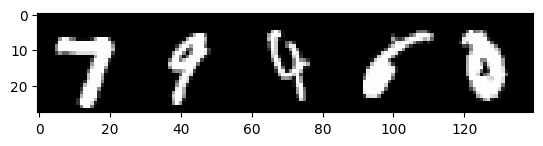

In [6]:
org_img = cv2.imread('data/YOLO_data_dg/images/100.png')
print(org_img.shape)
plt.imshow(org_img)
plt.show()

In [7]:
# so that the channel comes first (xdim, ydim, channel) -> (channel, xdim, ydim); threw an error when order different
# error: expected input[1, 128, 128, 3] to have 3 channels, but got 128 channels instead
input_img = np.moveaxis(org_img, -1, 0)
print(input_img.shape)

input_img = np.expand_dims(input_img, axis=0)
# input_img = np.expand_dims(input_img, axis=0)# to add (1,1,)
input_img.shape

(3, 28, 140)


(1, 3, 28, 140)

In [8]:
# set requires_grad to be true for the original image (1,3,28,140) before (1,3,128,128)
tensor_img = torch.tensor(np.array(input_img, dtype='float32'), requires_grad=True)
tensor_img.shape

# resize the image for YOLO
tensor_img_resized = resize_right.resize(tensor_img, out_shape=(1,3,256,256))
tensor_img_resized.shape

torch.Size([1, 3, 256, 256])

In [9]:
tensor_img_resized.max()

tensor(285.4918, grad_fn=<MaxBackward1>)

In [10]:
# definining batch with true label and bboxes to calculate the loss

batch = {'ori_shape': ((3, 28, 140),),
 'ratio_pad': None,
 'im_file': None,
 'img': None,
 'cls': torch.tensor([[7.],
         [9.],
         [4.],
         [6.],
         [0.]
                     ]).reshape(5),
 'bboxes': torch.tensor([[0.1250, 0.5000, 0.2250, 0.2250],
         [0.3750, 0.5000, 0.2250, 0.2250],
         [0.6250, 0.5000, 0.2250, 0.2250],
         [0.8750, 0.5000, 0.2250, 0.2250],
         [0.8750, 0.5000, 0.2250, 0.2250]]),
 'batch_idx': torch.tensor([0., 0., 0., 0., 0.])}

# resized image we feed to the model
batch['img'] = tensor_img_resized

In [11]:
# this is where backpropagation happens
a = trainer.model(tensor_img_resized)
loss_fn = Loss(trainer.model)
loss, _ = loss_fn(a, batch)
loss.backward()

In [12]:
print(loss)

tensor(14.3606, grad_fn=<MulBackward0>)


In [13]:
print(tensor_img.grad.shape)
tensor_img.grad

torch.Size([1, 3, 28, 140])


tensor([[[[ 9.1536e-04,  1.1808e-03, -1.3671e-03,  ...,  5.8867e-04,  4.3792e-04,  4.6393e-04],
          [-1.3149e-03,  3.6695e-04, -3.8543e-04,  ...,  1.4998e-05,  7.1559e-04,  3.9717e-04],
          [-1.6528e-03, -1.1952e-03,  2.3984e-03,  ..., -2.6978e-03, -2.3650e-03,  4.9281e-04],
          ...,
          [ 6.8879e-04,  1.1435e-03,  8.3582e-04,  ..., -2.0210e-03, -1.0893e-03,  8.0927e-04],
          [ 1.1551e-03,  1.7184e-03,  1.5616e-04,  ...,  8.5205e-04,  1.9500e-03, -3.7832e-04],
          [-3.8325e-05, -4.7441e-04, -1.1236e-03,  ...,  2.2694e-03,  1.2795e-03, -8.0508e-04]],

         [[-8.5933e-03,  1.1500e-03,  1.5288e-03,  ...,  1.4924e-03,  1.8453e-04,  6.3647e-04],
          [-4.6028e-03,  6.7764e-03, -6.0091e-03,  ..., -1.6566e-03, -1.7389e-03, -2.3694e-04],
          [ 1.0196e-02,  2.5366e-03, -5.6981e-03,  ..., -2.7249e-03,  3.9234e-03,  3.6391e-03],
          ...,
          [ 1.8855e-03, -7.3689e-04,  7.2566e-04,  ..., -5.4896e-03, -8.3693e-04,  2.3480e-03],
        

## one using loader (ignore)

In [29]:
loader = create_dataloader('../data/YOLO_data_dg/images', imgsz=128,
                           batch_size=32,
                           stride=1)

Scanning ../data/YOLO_data_dg/labels... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:02<00:00, 4769.37it/s]
New cache created: ../data/YOLO_data_dg/labels.cache


In [30]:
batch = next(iter(loader[0]))
batch['img'].shape

torch.Size([32, 3, 128, 128])

In [31]:
batch

{'ori_shape': ((28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140),
  (28, 140)),
 'ratio_pad': (((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.9142857142857143), (0.0, 51.0)),
  ((0.9285714285714286, 0.

In [34]:
batch['img'][0].shape

torch.Size([3, 128, 128])

In [23]:
# check if the batch['img'] is a leaf node; if it is .backward() accumulates grad
batch['img']=batch['img'].float()
print(batch['img'].is_leaf)
print(batch['img'].requires_grad)
batch['img'].requires_grad=True # additional argument to get the gradient of the input

True
False


In [24]:
batch['img'].shape

torch.Size([1, 3, 128, 128])

In [25]:
# batch variable set from the loader has cls (true label of the images)
# it reads the data from data=../detection_data.yaml, in args.yaml when calling the trainer
batch

{'ori_shape': ((28, 112),),
 'ratio_pad': (((1.1428571428571428, 1.1428571428571428), (0.0, 48.0)),),
 'im_file': ('../data/YOLO_short/images/0.png',),
 'img': tensor([[[[114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           ...,
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.]],
 
          [[114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           ...,
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.]],
 
          [[114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..

In [26]:
# this is where backpropagation happens
a = trainer.model(batch['img'])
loss_fn = Loss(trainer.model)
loss, _ = loss_fn(a, batch)
loss.backward()

In [27]:
(batch['img'].grad).shape # this version gives the gradient w.r.t. resized input

torch.Size([1, 3, 128, 128])

In [28]:
batch['img'].grad # checked that the gradient w.r.t. input is deterministic

tensor([[[[ 3.0678e-05, -1.8723e-04, -5.6495e-04,  ...,  5.5701e-03,  7.3125e-03,  5.1939e-03],
          [ 8.4913e-04,  4.8150e-05, -1.2031e-03,  ...,  6.1341e-03,  8.8653e-03,  5.9796e-03],
          [ 2.5488e-03,  7.3475e-04, -2.4057e-03,  ...,  5.9311e-03,  5.5987e-03,  3.4876e-03],
          ...,
          [-2.4228e-03, -9.3500e-04, -3.8466e-04,  ..., -5.1462e-03, -6.4833e-03, -4.9381e-03],
          [-4.3758e-03, -4.8144e-03, -3.6602e-03,  ..., -2.9989e-03, -2.8014e-03, -1.9724e-03],
          [-3.9081e-03, -4.6390e-03, -3.2471e-03,  ..., -2.5209e-03, -2.4373e-03, -1.9301e-03]],

         [[ 1.4024e-03,  8.5304e-04,  8.9985e-05,  ..., -1.8474e-03, -2.1638e-03, -2.6164e-03],
          [ 8.8364e-04,  4.5892e-04,  3.4072e-04,  ..., -2.0824e-03, -1.9692e-03, -2.5403e-03],
          [-3.0394e-04, -2.3936e-04,  5.9522e-04,  ..., -1.9198e-03, -1.9524e-03, -2.5911e-03],
          ...,
          [ 1.7990e-03,  1.2644e-03, -4.1133e-05,  ...,  1.7578e-03,  2.2166e-03,  1.9157e-03],
        

In [13]:
# #load the model
# model = YOLO("model_results/train7/weights/best.pt")
# res = model(data)
# # model.train(task='detect', data='../detection_data.yaml',
# #              epochs=1, batch=1, augment=False)